# Structural Break Tests

This notebook demonstrates the statistical tests for detecting structural breaks in time series.

**Topics covered:**
- Bai-Perron test (direct, from model, convenience method, integrated workflow)
- Chow test (known break point)
- CUSUM and CUSUM-SQ tests (parameter stability)
- Andrews-Ploberger test (unknown break date)
- Complementary workflow combining all tests

## Setup

In [1]:
import sys
from pathlib import Path

# Ensure the package is importable when running from the examples/ directory
sys.path.insert(0, str(Path("..") / "src"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import regimes as rg

print(f"regimes version: {rg.__version__}")

regimes version: 0.3.0


## Generate Sample Data

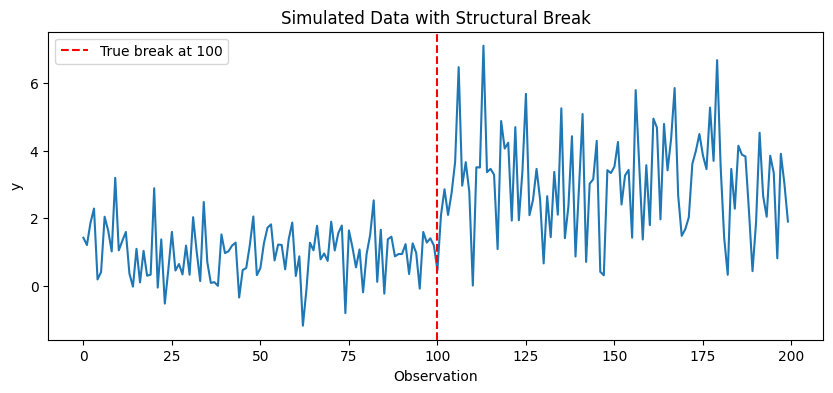

In [3]:
np.random.seed(42)
n = 200
break_point = 100

# Generate X (regressor)
X = np.random.randn(n)

# Generate y with different coefficients before/after break
y = np.zeros(n)
y[:break_point] = 1.0 + 0.5 * X[:break_point] + np.random.randn(break_point) * 0.5
y[break_point:] = 3.0 + 1.5 * X[break_point:] + np.random.randn(n - break_point) * 0.5

# Add constant to X for OLS
X_with_const = np.column_stack([np.ones(n), X])

# Plot the data
plt.figure(figsize=(10, 4))
plt.plot(y)
plt.axvline(x=break_point, color='r', linestyle='--', label=f'True break at {break_point}')
plt.xlabel('Observation')
plt.ylabel('y')
plt.title('Simulated Data with Structural Break')
plt.legend()
plt.show()

## Bai-Perron Test

### 4.1 Direct Usage — Mean Shift Only

The simplest form: test for breaks in the mean only (constant term). Pass just `y` with no other arguments.

In [4]:
bp_mean_shift = rg.BaiPerronTest(y)
bp_results_mean = bp_mean_shift.fit()
print(f"Detected breaks: {bp_results_mean.break_indices}")
print(bp_results_mean.summary())

Detected breaks: [101]
                  Bai-Perron Multiple Structural Break Test                   
Number of observations:          200
Trimming parameter:             0.15
Maximum breaks tested:             5
Breaking regressors (q):           1
------------------------------------------------------------------------------

Sup-F Tests (H0: 0 breaks vs H1: m breaks):
    m        Sup-F     Critical      p-value     Reject
---------------------------------------------------
    1      166.447        8.580       0.0000        Yes
    2       83.684        7.220       0.0000        Yes
    3       56.432        5.960       0.0000        Yes
    4       42.227        4.990       0.0000        Yes
    5       33.794        4.090       0.0000        Yes

UDmax statistic: 166.447 (5% critical: 8.880)
  => Reject null of no breaks

Sequential Sup-F Tests (H0: m breaks vs H1: m+1 breaks):
    m   m+1        Seq-F     Critical     Reject
----------------------------------------------
    0  

### 4.2 Direct Usage — All Regressors Break

Use `exog_break=` to specify regressors whose coefficients can all change at breaks.

In [5]:
bp_all_break = rg.BaiPerronTest(y, exog_break=X_with_const)
bp_results_all = bp_all_break.fit()
print(f"Detected breaks: {bp_results_all.break_indices}")
print(bp_results_all.summary())

Detected breaks: [101]
                  Bai-Perron Multiple Structural Break Test                   
Number of observations:          200
Trimming parameter:             0.15
Maximum breaks tested:             5
Breaking regressors (q):           2
------------------------------------------------------------------------------

Sup-F Tests (H0: 0 breaks vs H1: m breaks):
    m        Sup-F     Critical      p-value     Reject
---------------------------------------------------
    1      470.023       10.130       0.0000        Yes
    2      242.703        8.510       0.0000        Yes
    3      162.766        7.420       0.0000        Yes
    4      122.974        6.380       0.0000        Yes
    5       98.808        5.600       0.0000        Yes

UDmax statistic: 470.023 (5% critical: 10.550)
  => Reject null of no breaks

Sequential Sup-F Tests (H0: m breaks vs H1: m+1 breaks):
    m   m+1        Seq-F     Critical     Reject
----------------------------------------------
    0 

### 4.3 Direct Usage — Mixed Breaking/Non-Breaking Regressors

Use `exog=` for regressors with stable coefficients and `exog_break=` for those that may change. Here all regressors are included but only the constant breaks.

In [6]:
bp_mixed = rg.BaiPerronTest(y, exog=X_with_const)  # exog_break defaults to constant
bp_results_mixed = bp_mixed.fit()
print(f"Detected breaks: {bp_results_mixed.break_indices}")
print(bp_results_mixed.summary())

Detected breaks: [35, 101]
                  Bai-Perron Multiple Structural Break Test                   
Number of observations:          200
Trimming parameter:             0.15
Maximum breaks tested:             5
Breaking regressors (q):           1
------------------------------------------------------------------------------

Sup-F Tests (H0: 0 breaks vs H1: m breaks):
    m        Sup-F     Critical      p-value     Reject
---------------------------------------------------
    1      940.047        8.580       0.0000        Yes
    2      487.909        7.220       0.0000        Yes
    3      328.923        5.960       0.0000        Yes
    4      249.831        4.990       0.0000        Yes
    5      201.820        4.090       0.0000        Yes

UDmax statistic: 940.047 (5% critical: 8.880)
  => Reject null of no breaks

Sequential Sup-F Tests (H0: m breaks vs H1: m+1 breaks):
    m   m+1        Seq-F     Critical     Reject
----------------------------------------------
   

### 4.4 From OLS Model — `BaiPerronTest.from_model()`

Create a Bai-Perron test directly from an existing OLS model. The `break_vars` parameter controls which coefficients can break.

In [7]:
# Create OLS model
model = rg.OLS(y, X_with_const, has_constant=False)

# Create Bai-Perron test from the model
bp_from_model = rg.BaiPerronTest.from_model(model, break_vars="all")
bp_results_from_model = bp_from_model.fit()
print(f"Detected breaks: {bp_results_from_model.break_indices}")

Detected breaks: [101]


### 4.5 OLS Convenience Method — `model.bai_perron()`

The most convenient way: call `.bai_perron()` directly on a model object. Combines model creation and test in one step.

In [8]:
# Create model and run Bai-Perron in one step
model = rg.OLS(y, X_with_const, has_constant=False)
bp_results = model.bai_perron(break_vars="all", max_breaks=5, selection="bic")
print(f"Detected breaks: {bp_results.break_indices}")

Detected breaks: [101]


### 4.6 Convert Results to OLS — `bp_results.to_ols()`

Convert Bai-Perron results back to an OLS model with the detected breaks incorporated.

In [9]:
# Convert to OLS with detected breaks
ols_with_detected_breaks = bp_results.to_ols(cov_type="HC1")
print(ols_with_detected_breaks.summary())

                             OLS Regression Results                              
Dep. Variable:           y   No. Observations:           200
Model:                 OLS   Df Residuals:               196
Cov. Type:             HC1   Df Model:                     4
R-squared:          0.9056   Adj. R-squared:          0.9042
Residual Std Err:   0.4908   Residual Variance:       0.2409
Log-Likelihood:    -139.44   AIC:                     286.87
F-statistic:        626.99   BIC:                     300.07
Prob (F-statistic): 0.00e+00

---------------------------------------------------------------------------------
Structural Breaks
---------------------------------------------------------------------------------
Break at observation 101
  Regime 1: observations 0-100 (n=101)
  Regime 2: observations 101-199 (n=99)

                      coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------------
     x0_re

### 4.7 Integrated Workflow (Model → Test → Model with Breaks)

Complete workflow: start with a constant-parameter model, test for breaks, incorporate them.

In [10]:
# Step 1: Define and fit model without breaks
model = rg.OLS(y, X_with_const, has_constant=False)
constant_results = model.fit()
print("Step 1: Constant parameter model")
print(f"  Params: {constant_results.params}")

# Step 2: Test for breaks
bp_results = model.bai_perron()
print(f"\nStep 2: Bai-Perron detected {bp_results.n_breaks} break(s) at: {bp_results.break_indices}")

# Step 3: Convert to OLS with breaks
ols_with_breaks = bp_results.to_ols()
print(f"\nStep 3: Model with breaks")
print(ols_with_breaks.summary())

Step 1: Constant parameter model
  Params: [2.08044041 1.14639184]

Step 2: Bai-Perron detected 1 break(s) at: [101]

Step 3: Model with breaks
                             OLS Regression Results                              
Dep. Variable:           y   No. Observations:           200
Model:                 OLS   Df Residuals:               196
Cov. Type:       nonrobust   Df Model:                     4
R-squared:          0.9056   Adj. R-squared:          0.9042
Residual Std Err:   0.4908   Residual Variance:       0.2409
Log-Likelihood:    -139.44   AIC:                     286.87
F-statistic:        626.99   BIC:                     300.07
Prob (F-statistic): 0.00e+00

---------------------------------------------------------------------------------
Structural Breaks
---------------------------------------------------------------------------------
Break at observation 101
  Regime 1: observations 0-100 (n=101)
  Regime 2: observations 101-199 (n=99)

                      coef    

## Part 8: Chow Test

The **Chow test** (Chow, 1960) tests whether regression coefficients change at a *known* break point. Unlike Bai-Perron, which searches for unknown breaks, the Chow test evaluates a specific hypothesis: "did a structural break occur at date *t*?"

This makes the two tests complementary:
- **Bai-Perron**: "Where are the breaks?" (exploratory)
- **Chow**: "Is there a break at this specific date?" (confirmatory)

The test comes in two variants:
- **Standard**: Both sub-samples have enough observations to estimate separate regressions
- **Predictive**: One sub-sample is too small; tests whether the larger model can predict the smaller sample

### 8.1 Direct Usage

Test for a break at the true break point (t=100) and at a wrong location (t=80):

In [11]:
# Direct Chow test on y (uses constant-only model by default)
chow_test = rg.ChowTest(y)
chow_results = chow_test.fit(break_points=[100, 80])
print(chow_results.summary())

                          Chow Structural Break Test                          
Number of observations:          200
Number of parameters:              1
Significance level:            0.050
SSR (full sample):          500.3769
------------------------------------------------------------------------------

   Break       F-stat    df1    df2      p-value   Reject         Type
------------------------------------------------------------------
      80      88.2215      1    198     0.000000      Yes     Standard
     100     157.6914      1    198     0.000000      Yes     Standard
------------------------------------------------------------------------------

Rejected H0 at 2 of 2 tested break point(s)
Significant break(s) at: [80, 100]


### 8.2 From an OLS Model

The `.chow_test()` convenience method works on OLS, AR, and ADL models:

In [12]:
# Chow test via the OLS convenience method
model = rg.OLS(y, X_with_const, has_constant=False)
chow_from_model = model.chow_test(break_points=[100, 80])
print(chow_from_model.summary())

                          Chow Structural Break Test                          
Number of observations:          200
Number of parameters:              2
Significance level:            0.050
SSR (full sample):          273.6922
------------------------------------------------------------------------------

   Break       F-stat    df1    df2      p-value   Reject         Type
------------------------------------------------------------------
      80     132.1690      2    196     0.000000      Yes     Standard
     100     468.1295      2    196     0.000000      Yes     Standard
------------------------------------------------------------------------------

Rejected H0 at 2 of 2 tested break point(s)
Significant break(s) at: [80, 100]


### 8.3 Comparing Chow and Bai-Perron

A natural workflow: use Bai-Perron to *find* breaks, then use Chow to *confirm* them at specific dates:

In [13]:
# Step 1: Use Bai-Perron to find breaks
model = rg.OLS(y, X_with_const, has_constant=False)
bp_results = model.bai_perron()
print(f"Bai-Perron detected {bp_results.n_breaks} break(s) at: {bp_results.break_indices}")

# Step 2: Confirm detected breaks with Chow test
if bp_results.n_breaks > 0:
    chow_confirm = model.chow_test(break_points=list(bp_results.break_indices))
    print(f"\nChow test at Bai-Perron detected dates:")
    print(chow_confirm.summary())

Bai-Perron detected 1 break(s) at: [101]

Chow test at Bai-Perron detected dates:
                          Chow Structural Break Test                          
Number of observations:          200
Number of parameters:              2
Significance level:            0.050
SSR (full sample):          273.6922
------------------------------------------------------------------------------

   Break       F-stat    df1    df2      p-value   Reject         Type
------------------------------------------------------------------
     101     470.0235      2    196     0.000000      Yes     Standard
------------------------------------------------------------------------------

Rejected H0 at 1 of 1 tested break point(s)
Significant break(s) at: [101]


## Part 9: CUSUM Tests

The **CUSUM** (Cumulative Sum) and **CUSUM-SQ** (CUSUM of Squares) tests (Brown, Durbin, Evans, 1975) detect parameter instability *without* requiring a known break date.

- **CUSUM** detects shifts in the **mean/coefficients** — the cumulative sum of recursive residuals should stay within expanding boundaries under stability.
- **CUSUM-SQ** detects shifts in **variance** — the cumulative sum of *squared* recursive residuals should track the diagonal under stability.

These complement Bai-Perron (which *estimates* break locations) and Chow (which *tests* at known dates). CUSUM answers: "Is there instability *somewhere*?"

### 9.1 CUSUM Test

                     CUSUM Test for Parameter Instability                     
Number of observations:          200
Number of regressors:              1
Recursive residuals:             199
Significance level:            0.050
Sigma hat:                    1.5857
------------------------------------------------------------------------------
Max |CUSUM statistic|:       86.5837
Critical value (a):           0.9480

Decision:  REJECT the null of parameter stability
First boundary crossing at recursive residual index: 127


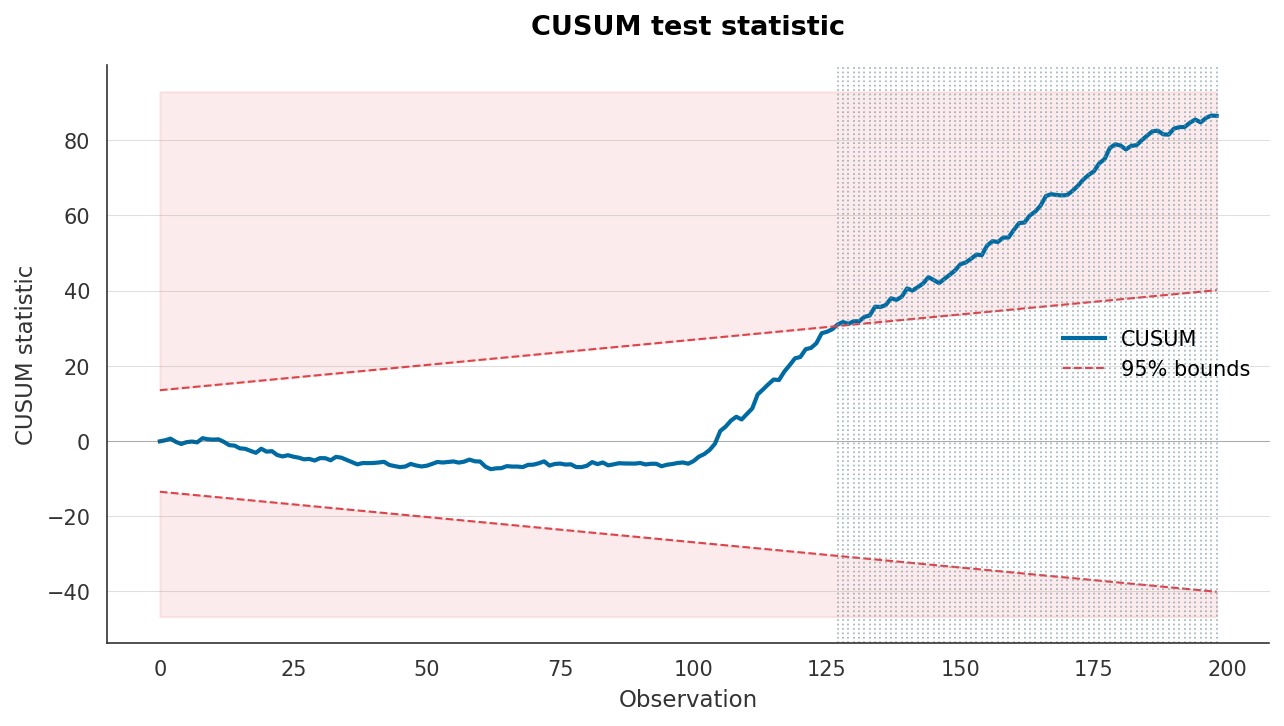

In [14]:
# CUSUM test on the y data (which has a mean shift at t=100)
cusum_test = rg.CUSUMTest(y)
cusum_results = cusum_test.fit(significance=0.05)
print(cusum_results.summary())
fig, ax = cusum_results.plot()

### 9.2 CUSUM-SQ Test

CUSUM-SQ is designed to detect changes in **variance** rather than in the mean. Let's create data with a variance shift:

                    CUSUM-SQ Test for Variance Instability                    
Number of observations:          200
Number of regressors:              1
Recursive residuals:             199
Significance level:            0.050
------------------------------------------------------------------------------
Max |S_r - E[S_r]|:           0.4359
KS critical value:            0.0954

Decision:  REJECT the null of variance stability
First boundary crossing at recursive residual index: 22


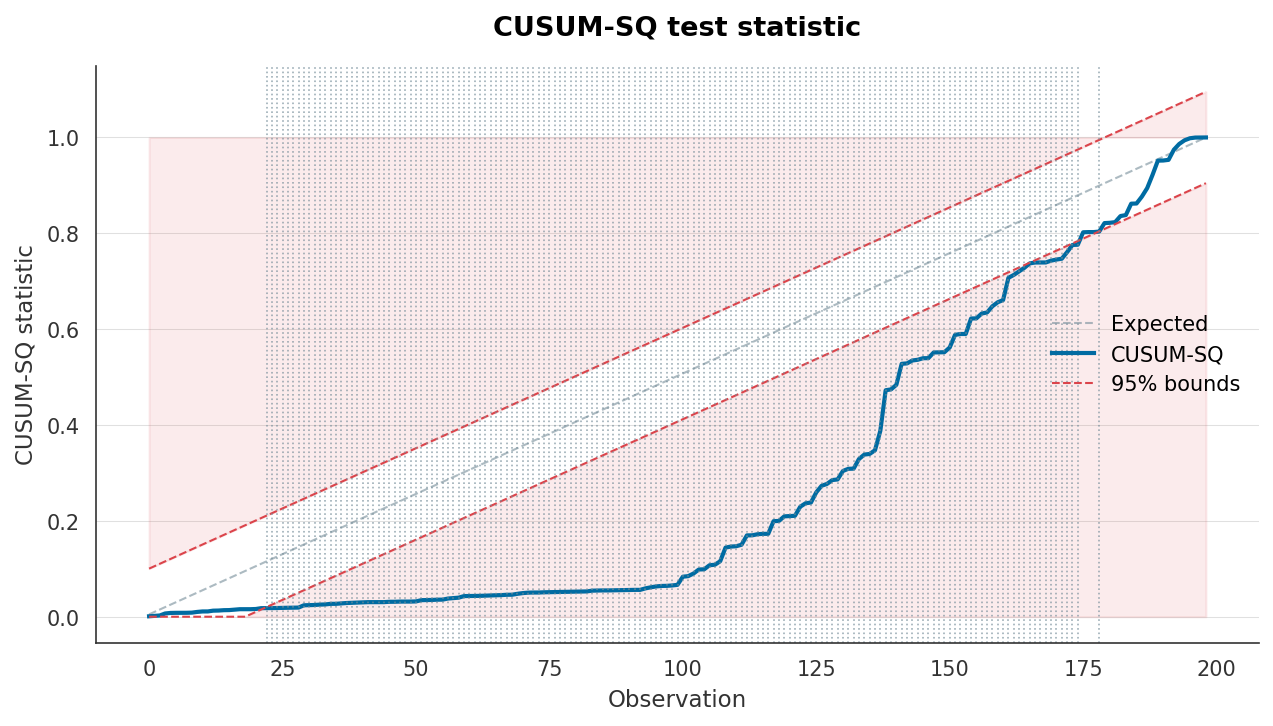

In [15]:
# Generate data with a variance change at t=100
rng = np.random.default_rng(42)
y_var = np.concatenate([rng.normal(0, 1, 100), rng.normal(0, 3, 100)])

# CUSUM-SQ test for variance instability
cusumsq_results = rg.CUSUMSQTest(y_var).fit(significance=0.05)
print(cusumsq_results.summary())
fig, ax = cusumsq_results.plot()

### 9.3 From a Model

The `.cusum_test()` and `.cusum_sq_test()` convenience methods work on OLS, AR, and ADL models — just like `.chow_test()` and `.bai_perron()`:

                     CUSUM Test for Parameter Instability                     
Number of observations:          200
Number of regressors:              2
Recursive residuals:             198
Significance level:            0.050
Sigma hat:                    1.1757
------------------------------------------------------------------------------
Max |CUSUM statistic|:      112.0231
Critical value (a):           0.9480

Decision:  REJECT the null of parameter stability
First boundary crossing at recursive residual index: 118


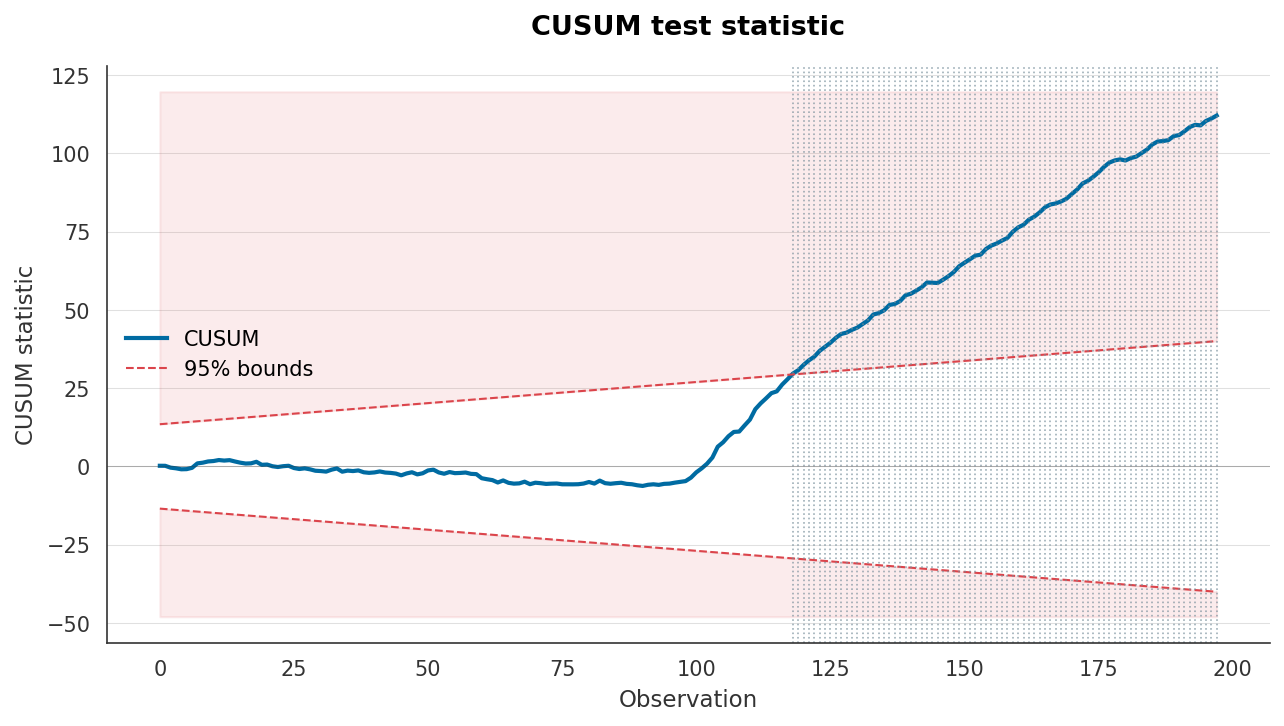

In [16]:
# CUSUM test via OLS convenience method
model = rg.OLS(y, X_with_const, has_constant=False)
cusum_from_model = model.cusum_test()
print(cusum_from_model.summary())
fig, ax = cusum_from_model.plot()

### 9.4 Complementary Workflow

CUSUM, Chow, and Bai-Perron serve different roles in a structural break analysis:

1. **CUSUM / CUSUM-SQ** → "Is there instability?" (detection, no known date required)
2. **Bai-Perron** → "Where are the breaks?" (estimation of break locations)
3. **Chow** → "Is there a break at *this* date?" (testing at a hypothesized date)

A natural workflow: start with CUSUM to screen for instability, use Bai-Perron to locate breaks, then confirm with Chow.

In [17]:
# Complete workflow: CUSUM → Bai-Perron → Chow
model = rg.OLS(y, X_with_const, has_constant=False)

# Step 1: Screen for instability with CUSUM
cusum = model.cusum_test()
print("=== Step 1: CUSUM Screening ===")
print(f"Rejects stability: {cusum.reject}\n")

# Step 2: Locate breaks with Bai-Perron
bp = model.bai_perron()
print("=== Step 2: Bai-Perron Break Location ===")
print(f"Detected {bp.n_breaks} break(s) at: {bp.break_indices}\n")

# Step 3: Confirm with Chow test at detected break(s)
chow = model.chow_test(break_points=list(bp.break_indices))
print("=== Step 3: Chow Confirmation ===")
print(chow.summary())

=== Step 1: CUSUM Screening ===
Rejects stability: True

=== Step 2: Bai-Perron Break Location ===
Detected 1 break(s) at: [101]

=== Step 3: Chow Confirmation ===
                          Chow Structural Break Test                          
Number of observations:          200
Number of parameters:              2
Significance level:            0.050
SSR (full sample):          273.6922
------------------------------------------------------------------------------

   Break       F-stat    df1    df2      p-value   Reject         Type
------------------------------------------------------------------
     101     470.0235      2    196     0.000000      Yes     Standard
------------------------------------------------------------------------------

Rejected H0 at 1 of 1 tested break point(s)
Significant break(s) at: [101]


## Part 10: Andrews-Ploberger Test

The **Andrews-Ploberger** test (Andrews, 1993; Andrews & Ploberger, 1994) tests for a **single structural break at an unknown date** by computing F-statistics at every candidate break date in a trimmed range, then aggregating them into three summary statistics:

- **SupF**: max F(τ) — powerful against a single sharp break
- **ExpF**: ln-average of exp(F/2) — optimal Bayesian average power
- **AveF**: average of F(τ) — detects diffuse instability

This complements the existing tests:
- **Bai-Perron**: "Where are the breaks?" (estimates multiple break locations)
- **Chow**: "Is there a break at *this* date?" (tests at a known date)
- **CUSUM**: "Is there instability?" (visual path-based detection)
- **Andrews-Ploberger**: "Is there a break *somewhere*?" (formal test, unknown single break)

### 10.1 Direct Usage

                   Andrews-Ploberger Structural Break Test                    
Number of observations:          200
Breaking parameters (q):           1
Non-breaking params (p):           0
Trimming:                       0.15
Significance level:            0.050
Estimated break date:            101
------------------------------------------------------------------------------

   Statistic        Value    CV(10%)     CV(5%)     CV(1%)    p-value   Reject
------------------------------------------------------------------------------
        SupF     166.4466       8.68      10.55      14.51     < 0.01      Yes
        ExpF      79.0178       2.51       3.42       5.48     < 0.01      Yes
        AveF      65.7089       3.26       4.26       6.47     < 0.01      Yes
------------------------------------------------------------------------------

Rejected H0 for 3 of 3 statistics at the 5% level


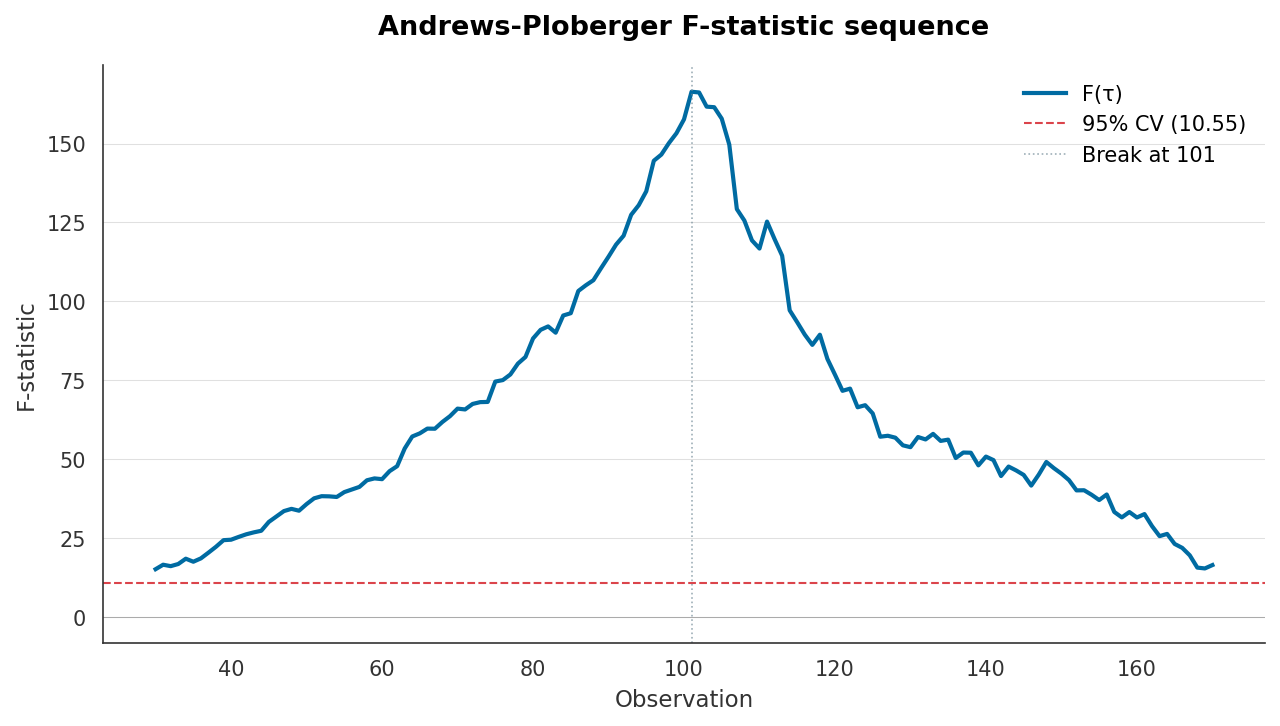

In [18]:
# Andrews-Ploberger test on y (which has a mean shift at t=100)
ap_test = rg.AndrewsPlobergerTest(y)
ap_results = ap_test.fit(trimming=0.15)
print(ap_results.summary())
fig, ax = ap_results.plot()

### 10.2 From a Model

The `.andrews_ploberger()` convenience method works on OLS, AR, and ADL models, automatically extracting `endog` and `exog` from the model:

                   Andrews-Ploberger Structural Break Test                    
Number of observations:          200
Breaking parameters (q):           2
Non-breaking params (p):           0
Trimming:                       0.15
Significance level:            0.050
Estimated break date:            101
------------------------------------------------------------------------------

   Statistic        Value    CV(10%)     CV(5%)     CV(1%)    p-value   Reject
------------------------------------------------------------------------------
        SupF     470.0235      10.69      12.57      16.56     < 0.01      Yes
        ExpF     230.3909       3.40       4.38       6.48     < 0.01      Yes
        AveF     105.3092       4.30       5.34       7.62     < 0.01      Yes
------------------------------------------------------------------------------

Rejected H0 for 3 of 3 statistics at the 5% level


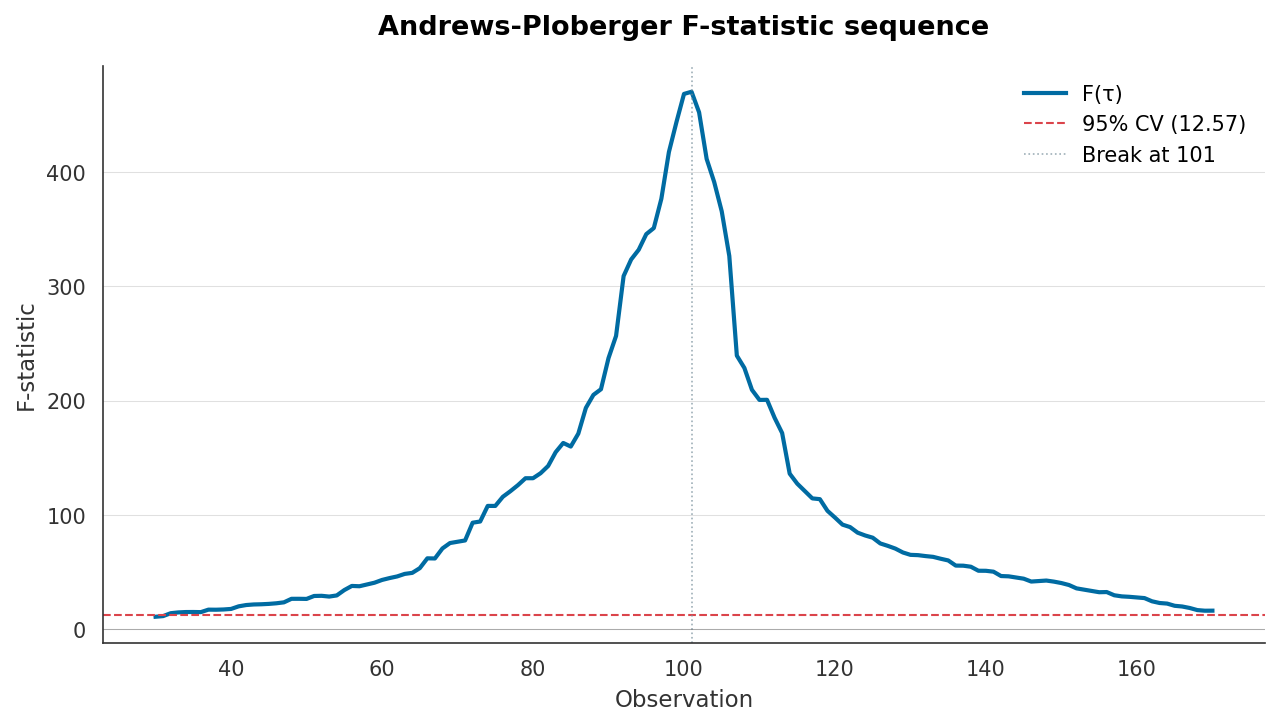

In [19]:
# Andrews-Ploberger via OLS convenience method
model = rg.OLS(y, X_with_const, has_constant=False)
ap_from_model = model.andrews_ploberger()
print(ap_from_model.summary())
fig, ax = ap_from_model.plot()

### 10.3 Updated Workflow

With Andrews-Ploberger, the recommended four-test workflow becomes:

1. **CUSUM** — Quick visual screening for instability
2. **Andrews-Ploberger** — Formal test: "Is there a break somewhere?" (SupF for sharp breaks, ExpF/AveF for diffuse instability)
3. **Bai-Perron** — Locate the break(s): "Where exactly are the break(s)?"
4. **Chow** — Confirm at detected dates: "Is there really a break at this specific date?"

In [20]:
# Complete workflow: CUSUM → Andrews-Ploberger → Bai-Perron → Chow
model = rg.OLS(y, X_with_const, has_constant=False)

# Step 1: Screen for instability with CUSUM
cusum = model.cusum_test()
print("=== Step 1: CUSUM Screening ===")
print(f"Rejects stability: {cusum.reject}")

# Step 2: Formal test for unknown break with Andrews-Ploberger
ap = model.andrews_ploberger()
print("=== Step 2: Andrews-Ploberger Test ===")
print(f"SupF: {ap.sup_f:.2f} (p {"<" if ap.sup_f_pvalue < 0.05 else ">"} 0.05)")
print(f"Estimated break at: {ap.sup_f_break_index}")

# Step 3: Locate breaks with Bai-Perron
bp = model.bai_perron()
print("=== Step 3: Bai-Perron Break Location ===")
print(f"Detected {bp.n_breaks} break(s) at: {bp.break_indices}")

# Step 4: Confirm with Chow test at detected break(s)
chow = model.chow_test(break_points=list(bp.break_indices))
print("=== Step 4: Chow Confirmation ===")
print(chow.summary())

=== Step 1: CUSUM Screening ===
Rejects stability: True
=== Step 2: Andrews-Ploberger Test ===
SupF: 470.02 (p < 0.05)
Estimated break at: 101
=== Step 3: Bai-Perron Break Location ===
Detected 1 break(s) at: [101]
=== Step 4: Chow Confirmation ===
                          Chow Structural Break Test                          
Number of observations:          200
Number of parameters:              2
Significance level:            0.050
SSR (full sample):          273.6922
------------------------------------------------------------------------------

   Break       F-stat    df1    df2      p-value   Reject         Type
------------------------------------------------------------------
     101     470.0235      2    196     0.000000      Yes     Standard
------------------------------------------------------------------------------

Rejected H0 at 1 of 1 tested break point(s)
Significant break(s) at: [101]


The four tests are **complementary**, each answering a different question:

| Test | Question | Strength |
|------|----------|----------|
| CUSUM | Is there instability? | Quick visual screening |
| Andrews-Ploberger | Is there a break somewhere? | Formal test, optimal power |
| Bai-Perron | Where are the breaks? | Locates multiple breaks |
| Chow | Is there a break at this date? | Confirms specific dates |